In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.model_selection import train_test_split
from statsmodels.stats.outliers_influence import variance_inflation_factor

## Data
Dataset of fish

### Independent Features
- Three closely related measure of length (cm)
- Height and Width
- Species

### Dependent Variable
- Weight (g)

In [2]:
df = pd.read_csv("../data/Fish.csv")
df.head()

,Species,Weight,Length1,Length2,Length3,Height,Width
0,Bream,242.0,23.2,25.4,30.0,11.5200,4.0200
1,Bream,290.0,24.0,26.3,31.2,12.4800,4.3056
2,Bream,340.0,23.9,26.5,31.1,12.3778,4.6961
3,Bream,363.0,26.3,29.0,33.5,12.7300,4.4555
4,Bream,430.0,26.5,29.0,34.0,12.4440,5.1340


In [3]:
df.describe()

,Weight,Length1,Length2,Length3,Height,Width
count,159.000000,159.000000,159.000000,159.000000,159.000000,159.000000
mean,398.326415,26.247170,28.415723,31.227044,8.970994,4.417486
std,357.978317,9.996441,10.716328,11.610246,4.286208,1.685804
min,0.000000,7.500000,8.400000,8.800000,1.728400,1.047600
25%,120.000000,19.050000,21.000000,23.150000,5.944800,3.385650
50%,273.000000,25.200000,27.300000,29.400000,7.786000,4.248500
75%,650.000000,32.700000,35.500000,39.650000,12.365900,5.584500
max,1650.000000,59.000000,63.400000,68.000000,18.957000,8.142000


## Let's do a quick visual check for null values

Text(0.5, 1.0, 'Null Values')

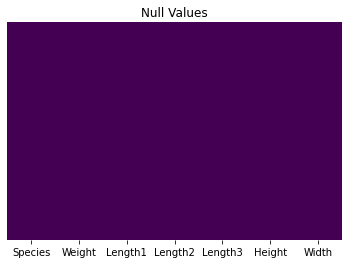

In [4]:
sns.heatmap(df.isnull(), cbar=False, cmap='viridis', yticklabels=False)
plt.title('Null Values')

Looks like we're good!

## A major issue with this dataset is multicollinearity

<AxesSubplot:>

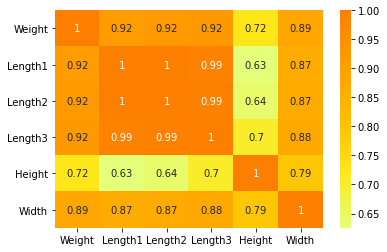

In [5]:
corr = df.corr()
sns.heatmap(corr, cmap='Wistia', annot=True)

The correlation matrix shows that the three length features are very closely correlated. So closely correlated, in fact, that we can toss two of them:

In [6]:
df = df.drop(labels=['Length1', 'Length2'], axis=1)

## Let's look at the distrubution of our dependent variable

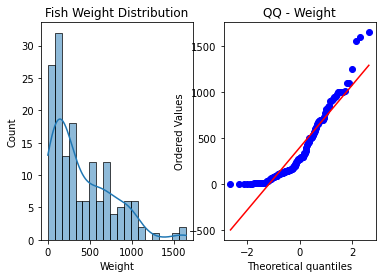

In [7]:
f = plt.figure()

ax = f.add_subplot(121)
sns.histplot(df['Weight'], bins=20, kde=True, ax=ax)
ax.set_title('Fish Weight Distribution')

ax = f.add_subplot(122)
stats.probplot(df['Weight'], dist=stats.norm, plot=ax)
ax.set_title('QQ - Weight')

plt.show()

This doesn't look very normally distributed, which could cause problems for use down the road. Let's see if a power transformation yields more normally distributed data:

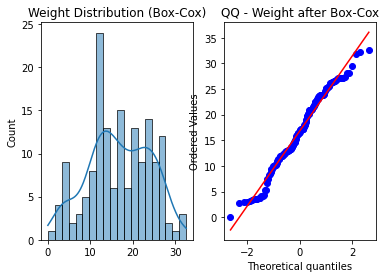

In [8]:
f = plt.figure()

weight_bc, lam = stats.boxcox(df['Weight'] + 1)
ax = f.add_subplot(121)
sns.histplot(weight_bc, bins=20, kde=True, ax=ax)
ax.set_title('Weight Distribution (Box-Cox)')

ax = f.add_subplot(122)
stats.probplot(weight_bc, dist=stats.norm, plot=ax)
ax.set_title('QQ - Weight after Box-Cox')

plt.show()

This looks much closer to the normal distribution: Let's replace our Weight feature with the transformed data.

In [9]:
df['Weight'] = weight_bc

## Question
- Does Linear Regression rely on an assumption that the independent variable is normally distributed?

## On your own
- Try comparing this model to a model trained on untransformed data. What differences do you notice?

## At first glance, does a linear relationship between length and weight make sense?

Text(0.5, 1.0, 'Weight vs. Vertical Length')

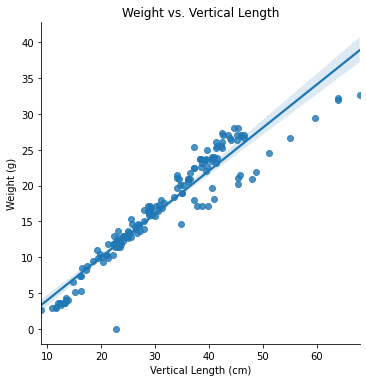

In [10]:
sns.lmplot(x='Length3', y="Weight", data=df)
plt.xlabel('Vertical Length (cm)')
plt.ylabel('Weight (g)')
plt.title('Weight vs. Vertical Length')

This model looks okay, but I notice there seem to be distinct sub-populations of fish. Let's see if fish species explains this:

Text(0.5, 1.0, 'Weight vs. Vertical Length')

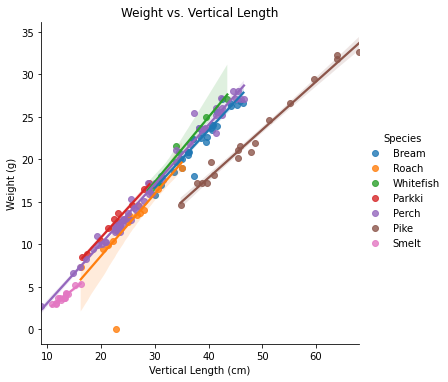

In [11]:
sns.lmplot(x='Length3', y="Weight", data=df, hue='Species')
plt.xlabel('Vertical Length (cm)')
plt.ylabel('Weight (g)')
plt.title('Weight vs. Vertical Length')

Looks like fish species is very important. Let's make sure we're able to incorporate this feature into our model!

## Handling Categorical Features

Let's use dummy variables:

In [12]:
df_dummies = pd.get_dummies(data = df, prefix = 'SP', prefix_sep='_',
    columns = ['Species'], drop_first =True, dtype='int8')

df_dummies.head()

,Weight,Length3,Height,Width,SP_Parkki,SP_Perch,SP_Pike,SP_Roach,SP_Smelt,SP_Whitefish
0,15.764896,30.0,11.5200,4.0200,0,0,0,0,0,0
1,16.929393,31.2,12.4800,4.3056,0,0,0,0,0,0
2,18.013306,31.1,12.3778,4.6961,0,0,0,0,0,0
3,18.476458,33.5,12.7300,4.4555,0,0,0,0,0,0
4,19.723304,34.0,12.4440,5.1340,0,0,0,0,0,0


## Question
- Why did we drop one of the dummy features (SP_Bream)?

## Let's split our data into training and test sets

In [13]:
X = df_dummies.drop('Weight', axis=1)
y = df_dummies['Weight']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=47)

Since our data is still highly collinear, we can likely benefit from principal component regression. Let's transform our data, holding on to the two most significant components

In [14]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X_train = pca.fit_transform(X_train)
pca.explained_variance_ratio_

array([0.93591861, 0.05844172])

We're ready to train our regression model!

In [15]:
from sklearn.linear_model import LinearRegression
lin_reg = LinearRegression()
lin_reg.fit(X_train,y_train) # Note: x_0 =1 is no need to add, sklearn will take care of it.

sk_theta = [lin_reg.intercept_]+list(lin_reg.coef_)
pd.Series(sk_theta, name='Sklearn_theta')

0    17.186800
1     0.577878
2    -0.386221
Name: Sklearn_theta, dtype: float64

How much of the variance in our dependent varialbe is explained by our model?

In [16]:
X_test = pca.transform(X_test)
y_pred = lin_reg.predict(X_test)
R_square = lin_reg.score(X_test,y_test)
R_square

0.9529105272560501

95% - That's very high

## Question
- How would you compute MSE?
- How would you interpret MSE (remember our power transformation)?

## Let's check our assumptions

Can we justify a linear relationship?

Text(0.5, 1.0, 'Actual Vs Predicted value')

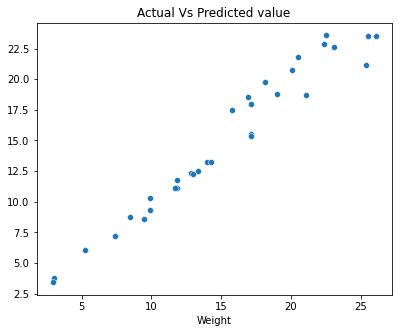

In [17]:
f = plt.figure(figsize=(14,5))
ax = f.add_subplot(121)
sns.scatterplot(x=y_test,y=y_pred,ax=ax)
ax.set_title('Actual Vs Predicted value')

There is no clear curvilinear trend here, so I think we can justify a linear relationship. This scatter plot hints that our residuals may be heteroscedastic, though.

## Distribution of residuals

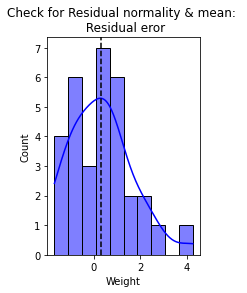

In [18]:
# Check for Residual normality & mean
f = plt.figure()
ax = f.add_subplot(121)
sns.histplot((y_test - y_pred),bins=10, ax=ax,color='b', kde=True)
ax.axvline((y_test - y_pred).mean(),color='k',linestyle='--')
ax.set_title('Check for Residual normality & mean: \n Residual eror');

The mean residual is close to 0, however the distribution is skewed to the right. Let' look closer at this distrubution:

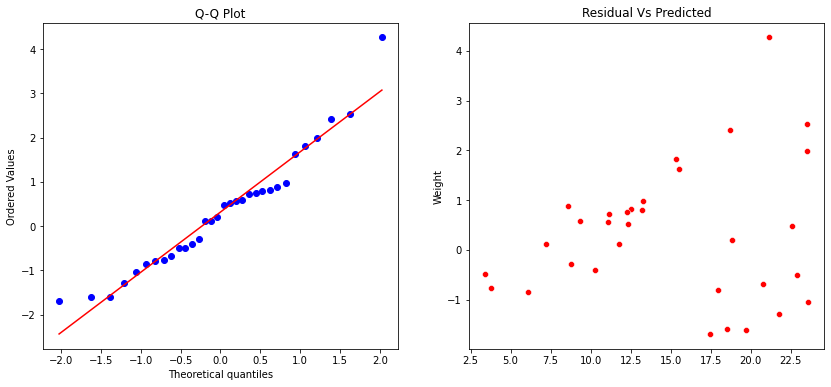

In [19]:
# Check for Multivariate Normality
# Quantile-Quantile plot 
f,ax = plt.subplots(1,2,figsize=(14,6))

_,(_,_,r)= stats.probplot((y_test - y_pred),fit=True,plot=ax[0])
ax[0].set_title('Q-Q Plot')

#Check for Homoscedasticity
sns.scatterplot(y = (y_test - y_pred), x= y_pred, ax = ax[1],color='r') 
ax[1].set_title('Residual Vs Predicted');

There is higher variance in the residuals corresponding to higher predicted weights. This indicates there may be trends in independent variable (weight) that aren't accounted for in our data.

## Question
- What would you try next?